# Example: Raycasting with Visualization 

There are two kinds of raycasts available: one that represents a view of the walls and one that represents a view of other entities.


**WARNING**:
There is an issue with this notebook that can lead to serious confusion.
You might interpret the raycasts as the view from the agent's perspective.
This is not wrong, but you have to keep in mind that the angles in the raycasts are ascending.
Ascending angles mean that they are sorted counterclockwise.
As a result the first entry of the raycast corresponds to what the agent sees at the right of it's field of view.
The last entry in the raycast corresponds to the left part of the field of view.
So you may interpret the raycasts as a field of view, but mirrored.
Pay attention to the asymetrical examples to see what is going on.
It is not necessarily possible to use descending angles.
At the time of writing, `compute_dist_bins` does not support descending bin boundaries.
There will be no error, just incorrect results!
`ray_casting_walls` seems to work either way.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from robofish.gym_guppy.tools.math import compute_dist_bins, ray_casting_walls

## Raycasting Walls


In [2]:
def top_view(own_pose, ray_orientations, ax):
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    for i, ray_angle in enumerate(ray_orientations):
        x = [own_pose[0], 2 * np.cos(ray_angle + own_pose[2]) + own_pose[0]]
        y = [own_pose[1], 2 * np.sin(ray_angle + own_pose[2]) + own_pose[1]]
        ax.plot(x, y, color="k", alpha=0.5)

    ax.scatter(own_pose[0], own_pose[1], color="k")
    ax.set_title("top view")


def vis(fish_pose, angle=90, n_rays=30):
    ray_orientations = np.linspace(
        -np.deg2rad(angle / 2), np.deg2rad(angle / 2), n_rays, dtype=np.float32
    )
    world_bounds = np.array([[-0.5, -0.5], [0.5, 0.5]], dtype=np.float32)
    max_dist = np.linalg.norm(world_bounds[0] - world_bounds[1])

    raycast = ray_casting_walls(
        fish_pose=fish_pose,
        world_bounds=world_bounds,
        ray_orientations=ray_orientations,
        max_dist=max_dist,
    )

    fig, axes = plt.subplots(nrows=2)
    axes[0].set_ylim(0, max_dist)
    axes[0].plot(np.rad2deg(ray_orientations), raycast, label="gym")
    axes[0].set_xlabel("angle [deg]")
    axes[0].set_ylabel("normed value")
    img = axes[1].imshow(raycast.reshape(1, -1), aspect="auto")
    axes[1].set_yticks([])
    axes[1].set_xlabel("ray index")
    fig.subplots_adjust(right=0.85, hspace=0.5)
    cbar_ax = fig.add_axes([0.88, 0.125, 0.04, 0.3])
    fig.colorbar(img, cax=cbar_ax)
    fig, ax = plt.subplots(figsize=(4, 4))
    top_view(own_pose=fish_pose, ray_orientations=ray_orientations, ax=ax)

The raycast of the walls gets calculated by measuring the distance from the agent to the walls.
The distance gets calculated in multiple angles across the field of view of the agent.
Each angle corresponds to one ray.
The distance gets normalized to [0, 1], where 0 corresponds to a distance of `max_dist`,
here the diagonal length of the world. A value of 1 corresponds to distance 0.

- The fish pose is x, y and orientation in radians.
- The first plot shows the result of the raycast, with the corresponding angles at the x axis.
- The second plot shows the same data, as a visualization of what the fish "sees".
  The corners appear dark, as they are usually more far away than the surrounding walls.
- The third plot is a top down view of the world, showing the agent, the rays and the walls.

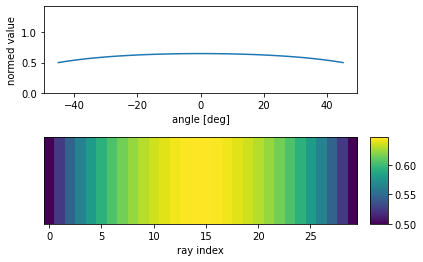

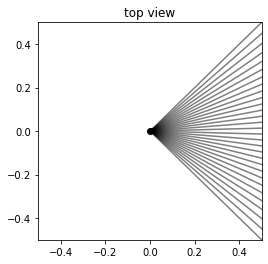

In [3]:
vis(fish_pose=[0, 0, 0])

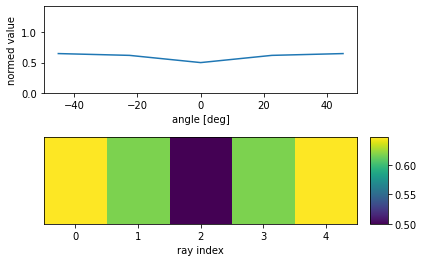

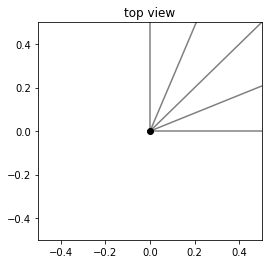

In [4]:
vis(fish_pose=[0, 0, np.pi / 4], n_rays=5)

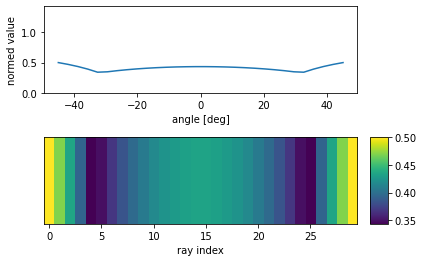

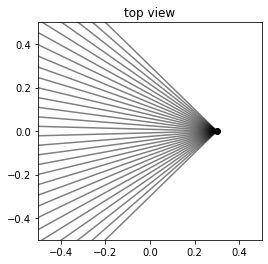

In [5]:
vis(fish_pose=[0.3, 0, -np.pi])

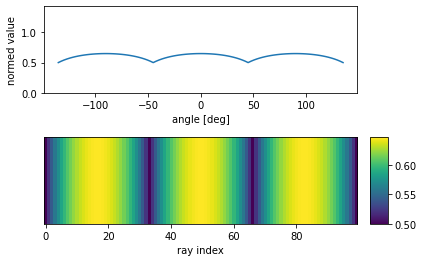

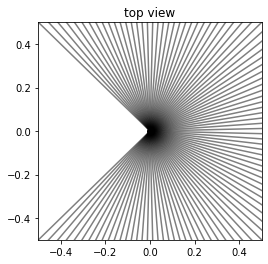

In [6]:
vis(fish_pose=[0, 0, 0], n_rays=100, angle=270)

Note: In this asymmetrical example, you see which bin is bin 0.

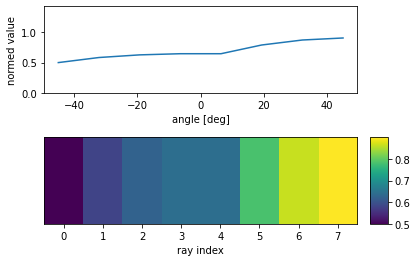

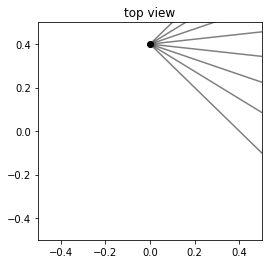

In [7]:
vis(fish_pose=[0, 0.4, 0], n_rays=8, angle=90)

## Raycasting Agents

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.46148354, 0.        , 0.        , 0.        ], dtype=float32)

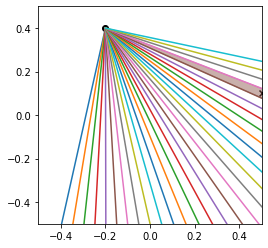

In [8]:
def vis_entities(own_pose, others, n_boundaries, angle=90):
    bin_boundaries = np.linspace(
        -np.deg2rad(angle / 2), np.deg2rad(angle / 2), n_boundaries, dtype=np.float32
    )
    raycast_gym = compute_dist_bins(
        relative_to=own_pose,
        poses=others,
        bin_boundaries=bin_boundaries,
        max_dist=np.sqrt(2),
    )

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    prev_x = None
    prev_y = None
    for i, bb in enumerate(bin_boundaries):
        x = [own_pose[0], 2 * np.cos(bb + own_pose[2]) + own_pose[0]]
        y = [own_pose[1], 2 * np.sin(bb + own_pose[2]) + own_pose[1]]
        ax.plot(x, y, label=str(i), color=f"C{i}")
        if prev_x and prev_y:
            ax.fill(
                np.concatenate([x, list(reversed(prev_x))]),
                np.concatenate([y, list(reversed(prev_y))]),
                color=f"C{i-1}",
                alpha=raycast_gym[i - 1],
            )
        prev_y = y
        prev_x = x

    ax.scatter(own_pose[0], own_pose[1], color="k")
    ax.scatter(others[:, 0], others[:, 1], color="k", marker="x")

    display(raycast_gym)


vis_entities(
    own_pose=np.array([-0.2, 0.4, -1]),
    others=np.array(
        [
            [0.5, 0.1, 0],
        ]
    ),
    n_boundaries=30,
)

If multiple entities are in one sector, the closest one counts:

array([0.8418861, 0.       , 0.       ], dtype=float32)

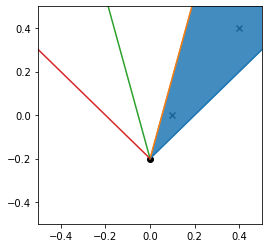

In [9]:
vis_entities(
    own_pose=np.array([0.0, -0.2, np.pi / 2]),
    others=np.array(
        [
            [0.4, 0.4, 0],
            [0.1, 0, 0],
        ]
    ),
    n_boundaries=4,
)

array([0.        , 0.        , 0.        , 0.765002  , 0.        ,
       0.        , 0.        , 0.6596592 , 0.7694099 , 0.66895187,
       0.7576815 , 0.        , 0.        , 0.67124707, 0.        ,
       0.        , 0.5745338 , 0.6870647 , 0.        , 0.6046808 ,
       0.6994301 , 0.6885177 , 0.        , 0.        , 0.        ,
       0.        , 0.6628052 , 0.        , 0.50241476, 0.        ,
       0.8320716 , 0.6736115 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

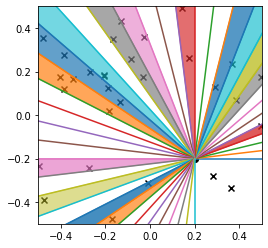

In [10]:
vis_entities(
    own_pose=np.array([0.2, -0.2, 0.75 * np.pi]),
    others=np.random.random((30, 3)) - 0.5,
    n_boundaries=40,
    angle=270,
)